In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
from sklearn.metrics import r2_score,mean_squared_error 

Using TensorFlow backend.


In [2]:
data = read_csv('dataset/irondata.csv')

In [3]:
data['date']=pd.to_datetime(data['date'],format='%d/%m/%Y')

In [4]:
data=data.sort_values('date')

In [5]:
df = data[:330]
test = data[330:]

In [6]:
df['price_lag']=df['price'].shift(1)
df['price_diff']=df['price_lag'].diff(periods=1)
df=df.set_index('date')
df['rolling_mean_price']=df['price_lag'].rolling(2, min_periods=1).sum()
df=df.dropna()
df.head()

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,price,price_lag,price_diff,rolling_mean_price
date,,,,
1990-03-31,14.05,14.05,0.0,28.1
1990-04-30,14.05,14.05,0.0,28.1
1990-05-31,14.05,14.05,0.0,28.1
1990-06-30,14.05,14.05,0.0,28.1
1990-07-31,14.05,14.05,0.0,28.1


In [7]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['price'] = min_max_scaler.fit_transform(df.price.values.reshape(-1,1))
    df['price_lag'] = min_max_scaler.fit_transform(df.price_lag.values.reshape(-1,1))
    df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [8]:
# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.head()

,price,price_lag,price_diff,rolling_mean_price
date,,,,
1990-03-31,0.014795,0.014795,0.0,0.01512
1990-04-30,0.014795,0.014795,0.0,0.01512
1990-05-31,0.014795,0.014795,0.0,0.01512
1990-06-30,0.014795,0.014795,0.0,0.01512
1990-07-31,0.014795,0.014795,0.0,0.01512


In [9]:
len(df_stock_norm)

328

In [10]:
X=df_stock_norm.drop(["price"],axis=1) 
y=df_stock_norm['price'] 
X_train = X[:-1] 
y_train=y[:-1]

In [11]:
X_train.head()

,price_lag,price_diff,rolling_mean_price
date,,,
1990-03-31,0.014795,0.0,0.01512
1990-04-30,0.014795,0.0,0.01512
1990-05-31,0.014795,0.0,0.01512
1990-06-30,0.014795,0.0,0.01512
1990-07-31,0.014795,0.0,0.01512


In [12]:
data_raw = X_train.as_matrix()

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [13]:
data_raw.shape

(327, 3)

In [14]:
print('x_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)

x_train.shape =  (327, 3)
y_train.shape =  (327,)


In [15]:
#Reshape data for (Sample,Timestep,Features) 
x_train = data_raw.reshape((data_raw.shape[0],1,X_train.shape[1]))

In [16]:
#Build the model
# model = Sequential()
# model.add(LSTM(256,input_shape=(4,1))) # 4 feature with one time stamps
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

model = Sequential()
    
model.add(LSTM(64, input_shape=(1,3), return_sequences=True)) # 3 feature with one time stamps
model.add(Dropout(0.3))

model.add(LSTM(64, input_shape=(1,3), return_sequences=False)) # 3 feature with one time stamps
model.add(Dropout(0.3))

model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# adam = keras.optimizers.Adam(decay=0.2)

start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.036900997161865234


In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 64)             17408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 52,545
Trainable params: 52,545
Non-trainable params: 0
__________________________________________________

In [18]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=20,validation_split=0.1,shuffle=False)


Train on 294 samples, validate on 33 samples
Epoch 1/20
294/294 [==============================] - 1s 3ms/step - loss: 0.1130 - accuracy: 0.0408 - val_loss: 0.0838 - val_accuracy: 0.0000e+00
Epoch 2/20
294/294 [==============================] - 0s 105us/step - loss: 0.1086 - accuracy: 0.0408 - val_loss: 0.0772 - val_accuracy: 0.0000e+00
Epoch 3/20
294/294 [==============================] - 0s 109us/step - loss: 0.1034 - accuracy: 0.0408 - val_loss: 0.0692 - val_accuracy: 0.0000e+00
Epoch 4/20
294/294 [==============================] - 0s 112us/step - loss: 0.0966 - accuracy: 0.0408 - val_loss: 0.0589 - val_accuracy: 0.0000e+00
Epoch 5/20
294/294 [==============================] - 0s 109us/step - loss: 0.0868 - accuracy: 0.0408 - val_loss: 0.0456 - val_accuracy: 0.0000e+00
Epoch 6/20
294/294 [==============================] - 0s 105us/step - loss: 0.0734 - accuracy: 0.0408 - val_loss: 0.0298 - val_accuracy: 0.0000e+00
Epoch 7/20
294/294 [==============================] - 0s 102us/step 

In [19]:
test_data=test.copy()
test_data['price'] = min_max_scaler.fit_transform(test_data.price.values.reshape(-1,1))
test_data['date']=pd.to_datetime(test_data['date'],format='%d/%m/%Y') 
test_data=test_data.sort_values('date') 
#test_data['Month']=test_data['date'].dt.month 
test_data=test_data.set_index('date')
#test_data['Month'] = min_max_scaler.fit_transform(test_data.Month.values.reshape(-1,1))
actual_price=pd.DataFrame() 
actual_price=test_data['price'] 
test_data=test_data.drop('price',axis=1) 
test_data.head()

""
date
2017-07-31
2017-08-31
2017-09-30
2017-10-31
2017-11-30


In [20]:
x = X[-1:].as_matrix()
test_forecast = np.reshape(x,(1,1,3))
t = model.predict(test_forecast)

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [21]:
temp = X[-1:]
temp = temp[['price_lag']]
n = temp.values.tolist()[0]
temp.head()

,price_lag
date,
2017-06-30,0.285552


In [22]:
print(t)
print(n)

[[0.52564347]]
[0.28555169862857793]


In [23]:
prediction=[]
kk = []
for i in range(1,len(test_data)+1):
    forecastdata=test_data[i-1:i] 
    o=forecastdata.values 
    y=list(np.append(o,t))
    forecast=pd.DataFrame(columns=['price_lag']) 
    forecast.loc[0]=n 
    forecast.loc[1]=y
    forecast['price_diff']=forecast['price_lag'].diff(periods=1) 
    forecast['rolling_mean_price']=forecast['price_lag'].rolling(2,min_periods=1).sum()
    x = forecast[-1:].as_matrix()
    new_val = np.reshape(x,(1,1,3))
    t=model.predict(new_val) 
    n=y 
    print(forecast) 
    print(t)
    prediction.append(t)
    kk.append(t)

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


   price_lag  price_diff  rolling_mean_price
0   0.285552         NaN            0.285552
1   0.525643    0.240092            0.811195
[[0.30103683]]
   price_lag  price_diff  rolling_mean_price
0   0.525643         NaN            0.525643
1   0.301037   -0.224607            0.826680
[[0.24963735]]
   price_lag  price_diff  rolling_mean_price
0   0.301037         NaN            0.301037
1   0.249637   -0.051399            0.550674
[[0.19588989]]
   price_lag  price_diff  rolling_mean_price
0   0.249637         NaN            0.249637
1   0.195890   -0.053747            0.445527
[[0.16872348]]
   price_lag  price_diff  rolling_mean_price
0   0.195890         NaN            0.195890
1   0.168723   -0.027166            0.364613
[[0.15135872]]
   price_lag  price_diff  rolling_mean_price
0   0.168723         NaN            0.168723
1   0.151359   -0.017365            0.320082
[[0.14145613]]
   price_lag  price_diff  rolling_mean_price
0   0.151359         NaN            0.151359
1   0.1414

In [24]:
pred = []
for i in range(len(prediction)):
    pred.append(prediction[i][0][0])

In [25]:
actual_price

date
2017-07-31    0.342771
2017-08-31    0.815663
2017-09-30    0.493373
2017-10-31    0.000000
2017-11-30    0.142169
2017-12-31    0.643976
2018-01-31    0.887349
2018-02-28    1.000000
2018-03-31    0.618675
2018-04-30    0.318072
2018-05-31    0.336145
2018-06-30    0.350000
2018-07-31    0.361446
2018-08-31    0.419880
2018-09-30    0.466867
2018-10-31    0.660843
2018-11-30    0.677711
2018-12-31    0.472892
Name: price, dtype: float64

In [26]:
predictdata=pd.DataFrame(pred,index=test_data.index,columns=['price']) 

In [27]:
def denormalize(df, normalized_value): 
    df = df['price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, np.array(pred))
newy_test = denormalize(test, np.array(actual_price))

In [28]:
import pandas as pd
act_pred = pd.concat([pd.DataFrame(newp), pd.DataFrame(newy_test)], axis=1)
act_pred.columns = ['Predicted', 'Actual']

In [29]:
act_pred

,Predicted,Actual
0,64.351204,66.74
1,55.318771,74.59
2,45.873734,69.24
3,41.099777,61.05
4,38.048267,63.41
5,36.308086,71.74
6,35.280617,75.78
7,34.686352,77.65
8,34.341095,71.32
9,34.141319,66.33


In [30]:
act_pred['date'] = predictdata.index

In [31]:
act_pred=act_pred.set_index('date')

In [32]:
act_pred

,Predicted,Actual
date,,
2017-07-31,64.351204,66.74
2017-08-31,55.318771,74.59
2017-09-30,45.873734,69.24
2017-10-31,41.099777,61.05
2017-11-30,38.048267,63.41
2017-12-31,36.308086,71.74
2018-01-31,35.280617,75.78
2018-02-28,34.686352,77.65
2018-03-31,34.341095,71.32


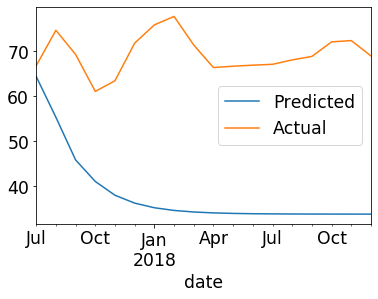

In [33]:
act_pred.plot()